In [1]:
import numpy as np
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
from sklearn.datasets import make_blobs, make_classification
from sklearn.cluster import SpectralClustering, KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform, cdist
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
import random
sns.set()
import sys
import time
import math

In [2]:
#components = 3
components = 3
# normalized = 1(unnormalized)/2(Lrw)/3(Lsys)
normalized = 1
# doesn't change anything normalizing vecs
normalized_vecs = False

colors = ['#4bd670', '#496fd6', '#b54e3a', '#a83fba']
max_eigenvalues = 10
max_eigenvectors = 4
max_changes = 10
split = 3

In [3]:
# works with 1:3, eigengap heuristic
def three_components():
    global X
    global y
    global W
    global n_clusters
    global start
    global end
    global eps
    
    eps = 3
    start = 1
    end = 3
    n_clusters = 3
    X = np.array([
        [1, 3], [2, 1], [1, 1],
        [3, 2], [7, 8], [9, 8],
        [9, 9], [8, 7], [13, 14],
        [14, 14], [15, 16], [14, 15]
    ])
    y = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]
    W = pairwise_distances(X, metric="euclidean")
    vectorizer = np.vectorize(lambda x: 1 if x < 5 else 0)
    W = np.vectorize(vectorizer)(W)

In [4]:
if components == 3:
    three_components()
else:
    sys.exit(0)

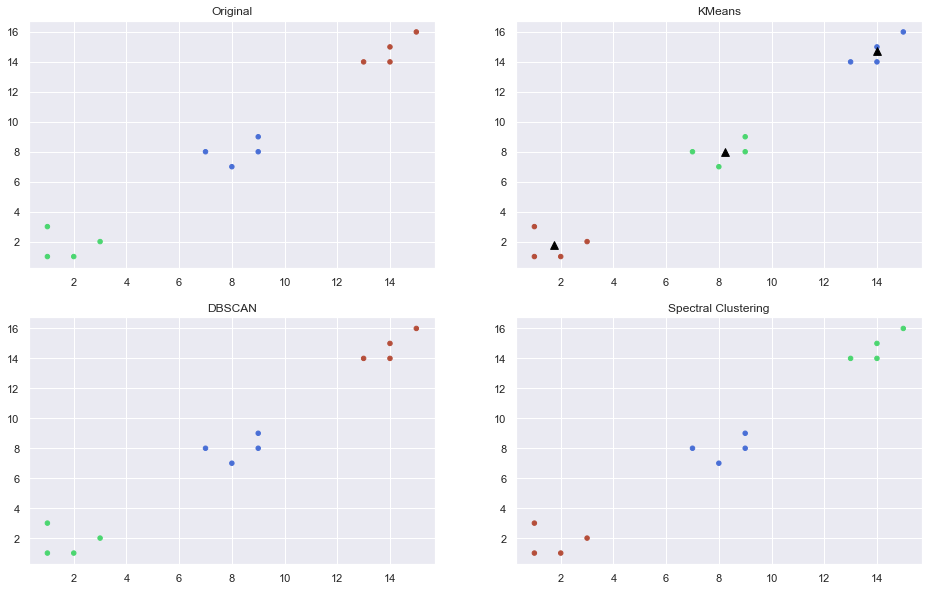

In [5]:
try:
    f, ax = plt.subplots(2, 2, figsize=(16, 10));
    
    col_clusters = [colors[i] for i in y]
    ax[0, 0].set_title('Original')
    ax[0, 0].scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);
    
    model = KMeans(n_clusters=n_clusters)
    model.fit(X)
    y_pred = model.predict(X)
    
    col_clusters = [colors[i] for i in y_pred]
    ax[0, 1].set_title('KMeans')
    ax[0, 1].scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);
    ax[0, 1].scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], marker='^', c='black', s=60)
    
    model = DBSCAN(eps=eps, min_samples=2)
    y_pred = model.fit_predict(X)
    col_clusters = [colors[i] for i in y_pred]
    ax[1, 0].set_title('DBSCAN')
    ax[1, 0].scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);
    
    model = SpectralClustering(n_clusters=n_clusters)
    y_pred = model.fit_predict(X)
    col_clusters = [colors[i] for i in y_pred]
    ax[1, 1].set_title('Spectral Clustering')
    ax[1, 1].scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);
except NameError:
    print("Doesn't have X")

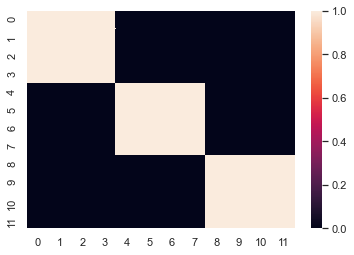

In [6]:
sns.heatmap(W);

In [7]:
def get_eigen(W):
    D = np.diag(np.sum(np.array(W), axis=1))
    L = D - W
    
    vals, vecs = np.linalg.eig(L)
    vals = vals.real
    vecs = vecs.real
    vecs = vecs[:,np.argsort(vals)]
    vals = vals[np.argsort(vals)]
    
    return vals, vecs

In [8]:
G = nx.from_numpy_matrix(W)
edges = list(G.edges())
G = nx.Graph()
G.add_edges_from(edges)
max_edges = int(len(W) * (len(W) - 1)/2)
edges_per_change = max_edges // max_changes

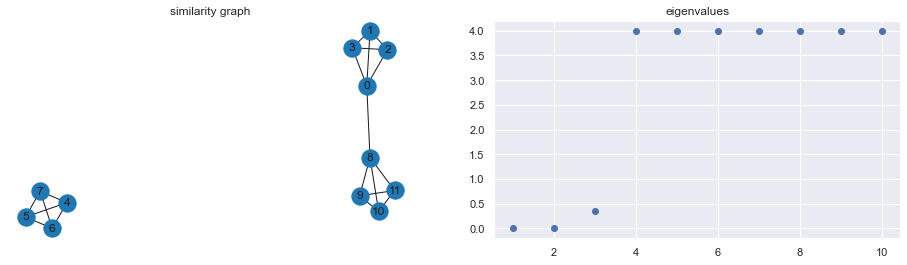

In [9]:
G.add_edge(8, 0)
vals, vecs = get_eigen(nx.adjacency_matrix(G).todense())
f, ax = plt.subplots(1, 2, figsize=(16, 4));
ax[0].set_title('similarity graph');
nx.draw(G, with_labels=True, ax=ax[0]);
ax[1].set_title('eigenvalues');
ax[1].plot(list(range(1, max_eigenvalues + 1)), vals[:max_eigenvalues], 'o');

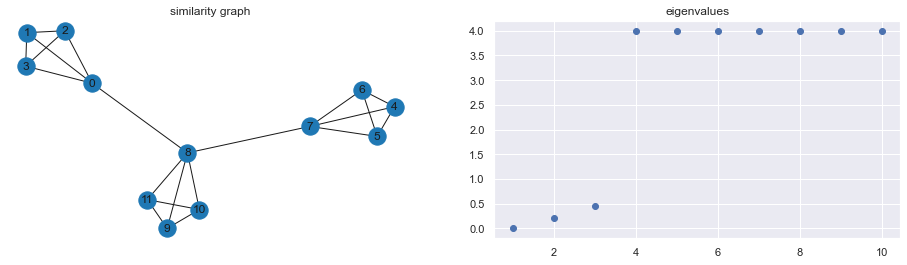

In [10]:
G.add_edge(8,7)
vals, vecs = get_eigen(nx.adjacency_matrix(G).todense())
f, ax = plt.subplots(1, 2, figsize=(16, 4));
ax[0].set_title('similarity graph');
nx.draw(G, with_labels=True, ax=ax[0]);
ax[1].set_title('eigenvalues');
ax[1].plot(list(range(1, max_eigenvalues + 1)), vals[:max_eigenvalues], 'o');

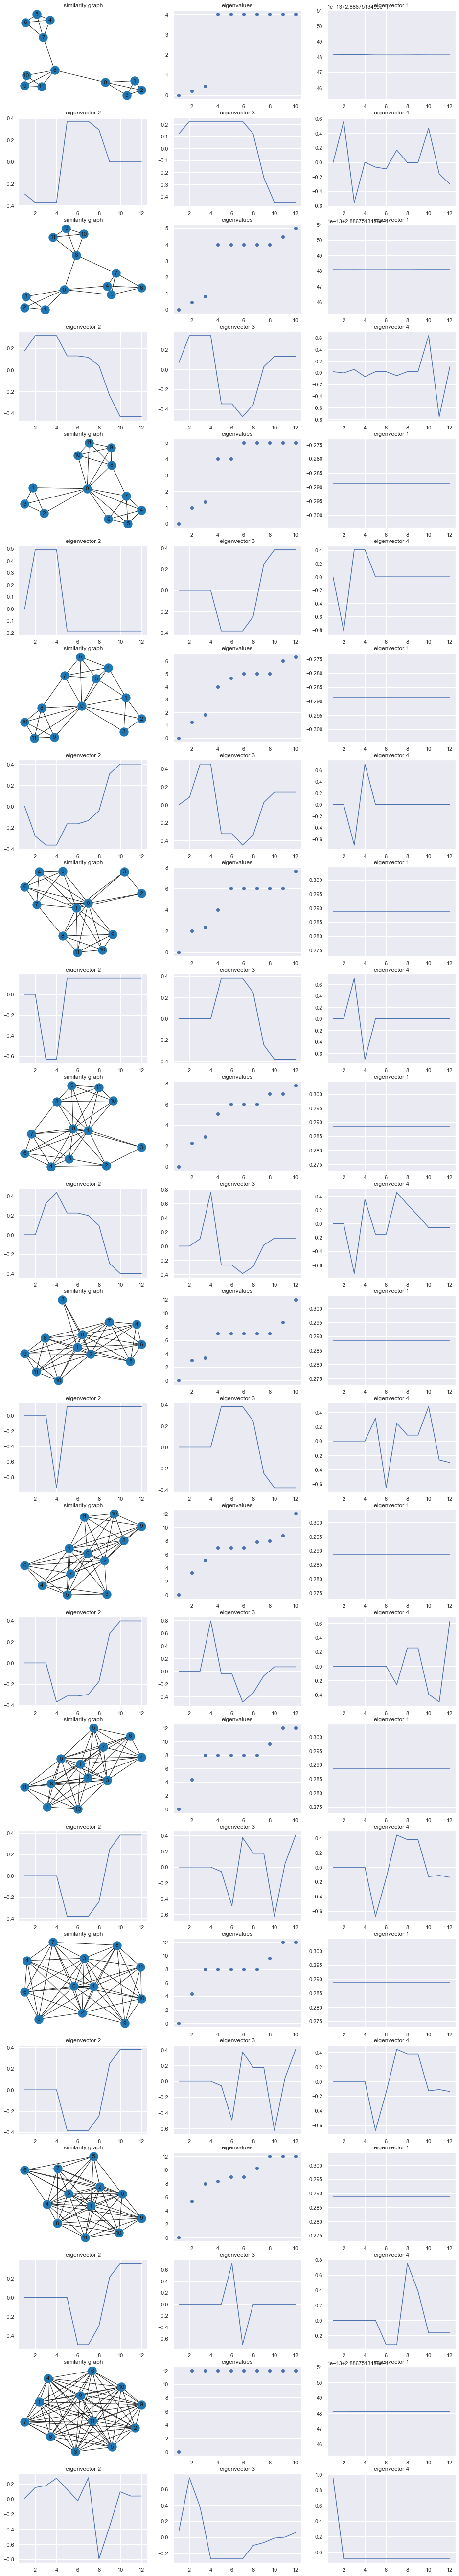

In [11]:
# max_eigenvectors has the similarity graph and the eigenvalues
individual_height = math.ceil((max_eigenvectors + 2) / split)
# changes has also the original and the completed
height = (max_changes + 2) * individual_height
f, ax = plt.subplots(
    height,
    split, 
    figsize=(16, height * 4));

# ORIGINAL
vals, vecs = get_eigen(nx.adjacency_matrix(G).todense())

ax[0, 0].set_title('similarity graph');
nx.draw(G, with_labels=True, ax=ax[0, 0]);
ax[0, 1].set_title('eigenvalues');
ax[0, 1].plot(list(range(1, max_eigenvalues + 1)), vals[:max_eigenvalues], 'o');

for i in range(2, max_eigenvectors + 2):
    ax[i // split, i % split].set_title(f'eigenvector {i - 1}');
    ax[i // split, i % split].plot(list(range(1, len(vals) + 1)), vecs[:, i - 2]);

i = 0
j = 0

# CHANGES
for change in range(1, max_changes + 1):
    # ADD X EDGES
    for _ in range(edges_per_change):
        if i != j:
            if (i, j) not in edges and (j, i) not in edges:
                G.add_edge(i, j)
                edges.append((i, j))
            
        j += 1
        if j == len(W):
            j = 0
            i += 1
            
    # PRINT FIGURE
    vals, vecs = get_eigen(nx.adjacency_matrix(G).todense())
    pos = change * individual_height
    ax[pos, 0].set_title('similarity graph');
    nx.draw(G, with_labels=True, ax=ax[pos, 0]);
    ax[pos, 1].set_title('eigenvalues');
    ax[pos, 1].plot(list(range(1, max_eigenvalues + 1)), vals[:max_eigenvalues], 'o');

    for pos_i in range(2, max_eigenvectors + 2):
        ax[pos + pos_i // split, pos_i % split].set_title(f'eigenvector {pos_i - 1}');
        ax[pos + pos_i // split, pos_i % split].plot(list(range(1, len(vals) + 1)), vecs[:, pos_i - 2]);
    
# COMPLETED
while i < len(W) and j < len(W):
    if i != j:
        if (i, j) not in edges and (j, i) not in edges:
            G.add_edge(i, j)
            edges.append((i, j))

    j += 1
    if j == len(W):
        j = 0
        i += 1
            
vals, vecs = get_eigen(nx.adjacency_matrix(G).todense())
pos += individual_height
ax[pos, 0].set_title('similarity graph');
nx.draw(G, with_labels=True, ax=ax[pos, 0]);
ax[pos, 1].set_title('eigenvalues');
ax[pos, 1].plot(list(range(1, max_eigenvalues + 1)), vals[:max_eigenvalues], 'o');

for i in range(2, max_eigenvectors + 2):
    ax[pos + i // split, i % split].set_title(f'eigenvector {i - 1}');
    ax[pos + i // split, i % split].plot(list(range(1, len(vals) + 1)), vecs[:, i - 2]);